In [ ]:
"""Calculate ppl replication experiment"""

In [2]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from accelerate.test_utils.testing import get_backend
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer
import nbimporter
from task_vectors import TaskVector
from safetensors.torch import load_file
from transformers import pipeline
import numpy as np
import evaluate
import pandas as pd

from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from accelerate.test_utils.testing import get_backend

from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from accelerate.test_utils.testing import get_backend

In [4]:
device, _, _ = get_backend() # automatically detects the underlying device type (CUDA, CPU, XPU, MPS, etc.)
model_id = "./pretrained_gpt2"
finetuned_model_path = "./fine_tuned_gpt2_frozen"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)


In [5]:
from datasets import load_dataset

test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

Token indices sequence length is longer than the specified maximum sequence length for this model (287644 > 1024). Running this sequence through the model will result in indexing errors


In [6]:
# Print to debug if data is loaded correctly
print(f"Loaded {len(test)} test samples from the Wikitext dataset.")
# Debugging encoding length
print(f"Total sequence length after encoding: {encodings.input_ids.size(1)}")

Loaded 4358 test samples from the Wikitext dataset.
Total sequence length after encoding: 287644


In [7]:
import torch
from tqdm import tqdm
import numpy as np
from detoxify import Detoxify
import gc
from copy import deepcopy
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load tokenizer and fix padding
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Required for some models

In [8]:
def normalize_weights(param_diff, eps=1e-6):
    norm = torch.norm(param_diff)
    return param_diff / (norm + eps)    
    
# Task Vector Class
class TaskVector:
    def __init__(self, pretrained_checkpoint, finetuned_checkpoint):
        # Keep models on CPU initially
        self.pretrained_model = AutoModelForCausalLM.from_pretrained(model_id).cpu()
        self.finetuned_model = AutoModelForCausalLM.from_pretrained(finetuned_model_path).cpu()

    def __neg__(self):
        neg_vector = TaskVector.__new__(TaskVector)
        neg_vector.pretrained_model = self.pretrained_model
        neg_vector.finetuned_model = self.finetuned_model
        for p_pre, p_fine in zip(
            neg_vector.pretrained_model.parameters(), neg_vector.finetuned_model.parameters()
        ):
            p_fine.data = p_pre.data - p_fine.data
        return neg_vector

    def apply_to(self, base_model, scaling_coef):
        # Move only temporarily
        self.pretrained_model.to(device)
        self.finetuned_model.to(device)
        base_model = base_model.to(device)
    
        for p_base, p_pre, p_fine in zip(
            base_model.parameters(),
            self.pretrained_model.parameters(),
            self.finetuned_model.parameters(),
        ):
            p_base.data += scaling_coef * normalize_weights(p_fine.data - p_pre.data)

        # Clear memory here for better memory management
        self.pretrained_model.to("cpu")
        self.finetuned_model.to("cpu")
        torch.cuda.empty_cache()

        return base_model


In [9]:
# Initialize Task Vectors
task_vector = TaskVector(model_id, finetuned_model_path)

# Scaling coefficients
scaling_factors = np.arange(-1.0, 1.1, 0.1)

In [10]:
prompt = "You're a real"

In [11]:
import torch
from tqdm import tqdm

def calculate_perplexity(model, tokenizer, encodings, device):
    max_length = model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    print(f"Sequence length: {seq_len} | Max length: {max_length} | Stride: {stride}")  # Debugging
    
    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0

    # Check how many iterations we will have based on stride
    num_iterations = (seq_len // stride) + 1
    print(f"Number of iterations for perplexity calculation: {num_iterations}")
    
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
    
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss
    
        # Accumulate the total negative log-likelihood and the total number of tokens
        num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens
    
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    
    avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
    ppl = torch.exp(avg_nll)
    print(f"Perplexity: {ppl.item():.2f}")
    return ppl.item()


In [12]:
# Generation function
def generate_text(model, tokenizer, prompt, num_samples=5, max_new_tokens=100, device='cuda'):
    model.eval()
    model.to(device)
    samples = []

    for _ in range(num_samples):
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        inputs['pad_token_id'] = tokenizer.pad_token_id

        with torch.no_grad():
            output = model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                pad_token_id=inputs['pad_token_id'],
                max_new_tokens=max_new_tokens,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=1.0,
            )
        text = tokenizer.decode(output[0], skip_special_tokens=True)
        samples.append(text)

    return samples


In [13]:
"""calculate ppl replication"""
from copy import deepcopy
import pandas as pd

# Load base model just once
base_model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

# Store results
neg_to_pos_ppl_results = []

for scale in scaling_factors:
    print(f"\n--- Scaling factor: {scale:.1f} ---")

    # Clone base model and apply task vector scaling
    scaled_model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
    task_vector.apply_to(scaled_model, scaling_coef=scale)

    # Calculate perplexity on Wikitext test set
    ppl = calculate_perplexity(scaled_model, tokenizer, encodings, device)

    # Store results for each scaling factor
    neg_to_pos_ppl_results.append((scale, ppl))

# Convert results to a DataFrame and save
ppl_df = pd.DataFrame(neg_to_pos_ppl_results, columns=['scaling_factor', 'ppl'])
ppl_df.to_csv("test_wikitext_ppl_results.csv", index=False)

print("Results saved to wikitext_ppl_results.csv")



--- Scaling factor: -1.0 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [03:47<00:00,  2.46it/s]


Perplexity: 44.70

--- Scaling factor: -0.9 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 40.04

--- Scaling factor: -0.8 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 36.40

--- Scaling factor: -0.7 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 33.58

--- Scaling factor: -0.6 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 31.39

--- Scaling factor: -0.5 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 29.66

--- Scaling factor: -0.4 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 28.27

--- Scaling factor: -0.3 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:13<00:01,  1.50it/s]


Perplexity: 27.15

--- Scaling factor: -0.2 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 26.27

--- Scaling factor: -0.1 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 25.61

--- Scaling factor: -0.0 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 25.17

--- Scaling factor: 0.1 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.51it/s]


Perplexity: 24.96

--- Scaling factor: 0.2 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 24.98

--- Scaling factor: 0.3 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:11<00:01,  1.51it/s]


Perplexity: 25.22

--- Scaling factor: 0.4 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:11<00:01,  1.51it/s]


Perplexity: 25.69

--- Scaling factor: 0.5 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 26.39

--- Scaling factor: 0.6 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 27.38

--- Scaling factor: 0.7 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 28.78

--- Scaling factor: 0.8 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:13<00:01,  1.50it/s]


Perplexity: 30.87

--- Scaling factor: 0.9 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:12<00:01,  1.50it/s]


Perplexity: 34.03

--- Scaling factor: 1.0 ---
Sequence length: 287644 | Max length: 1024 | Stride: 512
Number of iterations for perplexity calculation: 562


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:13<00:01,  1.50it/s]

Perplexity: 38.77
Results saved to wikitext_ppl_results.csv


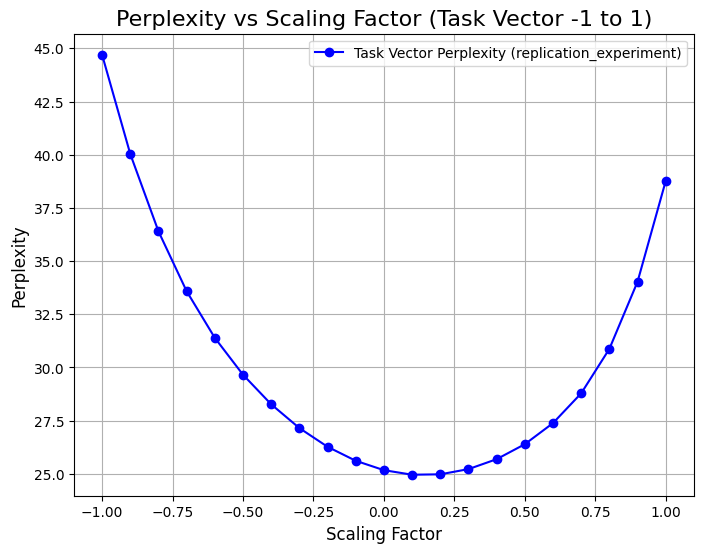

In [14]:
"""visaulize ppl"""
import matplotlib.pyplot as plt
import pandas as pd

# Load the saved CSV file into a DataFrame
ppl_df = pd.read_csv("test_wikitext_ppl_results.csv")

# Filter for scaling_factor >= -0.5
#filtered_df = ppl_df[ppl_df['scaling_factor'] >= -0.5]
filtered_df = ppl_df[(ppl_df["scaling_factor"]>= -1.0) & (ppl_df["scaling_factor"] <= 1.0)]

# Assuming the DataFrame has columns named 'scale' and 'perplexity'
scaling_factors_pos = ppl_df['scaling_factor'] #<---- needs to change to ppl_df to remove filter
perplexities_pos = ppl_df['ppl'] #<---- needs to change to ppl_df to remove filter

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(scaling_factors_pos, perplexities_pos, marker='o', color='b', label="Task Vector Perplexity (replication_experiment)")
plt.title("Perplexity vs Scaling Factor (Task Vector -1 to 1)", fontsize=16)
plt.xlabel("Scaling Factor", fontsize=12)
plt.ylabel("Perplexity", fontsize=12)
plt.grid(True)
plt.legend()

# Save the plot
plt.savefig("test_ppl_plot_replication_full_scale.png", dpi=300)

plt.show()

In [15]:
import pandas as pd

# Load the CSV file
file_path = "test_wikitext_ppl_results.csv"
df = pd.read_csv(file_path)

# Round the 'scaling_factor' to the nearest one-decimal place and the ppl to 2 decimal places
df['scaling_factor'] = df['scaling_factor'].round(1)
df['ppl'] = df['ppl'].round(2)

# Sort the dataframe based on 'scaling_factor' from -1.0 to 1.0
df = df.sort_values(by='scaling_factor', ascending=True)

# Save the modified CSV to a new file
output_file_path = "test_wikitext_ppl_results_sorted.csv"
df.to_csv(output_file_path, index=False)

print(f"File saved as {output_file_path}")


File saved as test_wikitext_ppl_results_sorted.csv


In [16]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("test_wikitext_ppl_results_sorted.csv")

# Print the scores (scaling_factor and perplexity values)
print("Scaling Factor | Perplexity (PPL)")
print("----------------|----------------")

# Loop through the DataFrame and print the scaling factor and perplexity
for index, row in df.iterrows():
    print(f"{row['scaling_factor']}           | {row['ppl']}")

Scaling Factor | Perplexity (PPL)
----------------|----------------
-1.0           | 44.7
-0.9           | 40.04
-0.8           | 36.4
-0.7           | 33.58
-0.6           | 31.39
-0.5           | 29.66
-0.4           | 28.27
-0.3           | 27.15
-0.2           | 26.27
-0.1           | 25.61
-0.0           | 25.17
0.1           | 24.96
0.2           | 24.98
0.3           | 25.22
0.4           | 25.69
0.5           | 26.39
0.6           | 27.38
0.7           | 28.78
0.8           | 30.87
0.9           | 34.03
1.0           | 38.77


In [17]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("test_wikitext_ppl_results_sorted.csv")

# Find the perplexity score at scaling_factor 0.0
ppl_at_0 = df[df['scaling_factor'] == 0.0]['ppl'].values[0]

# Add a new column for the span (difference) relative to scaling_factor 0.0
df['span_from_0'] = df['ppl'] - ppl_at_0

# Print the results
print("Scaling Factor | Perplexity (PPL) | Span from 0.0")
print("----------------|------------------|----------------")

# Loop through the DataFrame and print the scaling factor, perplexity, and span
for index, row in df.iterrows():
    print(f"{row['scaling_factor']}           | {row['ppl']}           | {row['span_from_0']:.2f}")


Scaling Factor | Perplexity (PPL) | Span from 0.0
----------------|------------------|----------------
-1.0           | 44.7           | 19.53
-0.9           | 40.04           | 14.87
-0.8           | 36.4           | 11.23
-0.7           | 33.58           | 8.41
-0.6           | 31.39           | 6.22
-0.5           | 29.66           | 4.49
-0.4           | 28.27           | 3.10
-0.3           | 27.15           | 1.98
-0.2           | 26.27           | 1.10
-0.1           | 25.61           | 0.44
-0.0           | 25.17           | 0.00
0.1           | 24.96           | -0.21
0.2           | 24.98           | -0.19
0.3           | 25.22           | 0.05
0.4           | 25.69           | 0.52
0.5           | 26.39           | 1.22
0.6           | 27.38           | 2.21
0.7           | 28.78           | 3.61
0.8           | 30.87           | 5.70
0.9           | 34.03           | 8.86
1.0           | 38.77           | 13.60
